In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
house = pd.read_csv('./datasets/train_new.csv')
house_test=pd.read_csv('./datasets/test.csv')

C:\Users\wongh\AppData\Local\Temp\ipykernel_9660\3092648055.py:2: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  house_test=pd.read_csv('./datasets/test.csv')


In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   flat_type             150634 non-null  object 
 1   floor_area_sqm        150634 non-null  float64
 2   flat_model            150634 non-null  object 
 3   resale_price          150634 non-null  float64
 4   town                  150634 non-null  object 
 5   Tranc_Year            150634 non-null  int64  
 6   mid                   150634 non-null  int64  
 7   mrt_nearest_distance  150634 non-null  float64
 8   dist_from_city        150634 non-null  float64
 9   age_at_tranc          150634 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 11.5+ MB


In [5]:
# Creating dist_from_city column in test set
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])

    # Compute the Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Raffles Place coordinates
raffles_place_latitude, raffles_place_longitude = 1.2833, 103.8501

# Calculate the distance between each location and Raffles Place
house_test['dist_from_city'] = haversine_distance(house_test['Latitude'], house_test['Longitude'],
                                                       raffles_place_latitude, raffles_place_longitude)

In [6]:
# Creating age_at_tranc column in test set
house_test['age_at_tranc']=house_test['Tranc_Year']-house_test['lease_commence_date']

In [7]:
X=house.drop('resale_price',axis=1)
y=house['resale_price']

In [8]:
# Creating the numerical and categorical columns
cat_cols = [cname for cname in X.columns if X[cname].dtype == 'object']
num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

In [9]:
# Split the data using train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Linear Regression

### Baseline Prediction (Linear Regression)

In [10]:
# set up the column transformer to apply OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), cat_cols), ('num', StandardScaler(), num_cols)
        ])
    
# set up the pipeline for Linear Regression
pipeline_lr = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())])

In [11]:
# Checking the Linear Regression r2 scores
pipeline_lr_scores = cross_val_score(pipeline_lr, X, y, cv=10)

print (pipeline_lr_scores)
print (np.mean(pipeline_lr_scores))

[0.87129563 0.87492892 0.87473544 0.87373578 0.87343918 0.87475577
 0.87361353 0.87252337 0.87011945 0.87440957]
0.8733556645314554


In [12]:
# Fit the model with training data
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['flat_type', 'flat_model',
                                                   'town']),
                                                 ('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'Tranc_Year', 'mid',
                                                   'mrt_nearest_distance',
                                                   'dist_from_city',
                                                   'age_at_tranc'])])),
                ('model', LinearRegression())])

In [13]:
print(f"The train score is: {round(pipeline_lr.score(X_train, y_train), 6)}")
print(f"The test score is: {round(pipeline_lr.score(X_test, y_test), 6)}")

The train score is: 0.874072
The test score is: 0.871259


The R2 scores for both train and test sets are similar, implying the model is performing well and not overfitting or underfitting the data.

In [14]:
# Obtaining the features and its corresponding coef
coef=pipeline_lr.named_steps['model'].coef_
features=pipeline_lr[:-1].get_feature_names_out()

In [15]:
df_coef=pd.DataFrame({'Features':features,'Coefficients':coef})
df_coef.head()

,Features,Coefficients
0,cat__flat_type_1 ROOM,-50606.432520
1,cat__flat_type_2 ROOM,-49025.901925
2,cat__flat_type_3 ROOM,-13349.644066
3,cat__flat_type_4 ROOM,7999.411418
4,cat__flat_type_5 ROOM,29272.560862


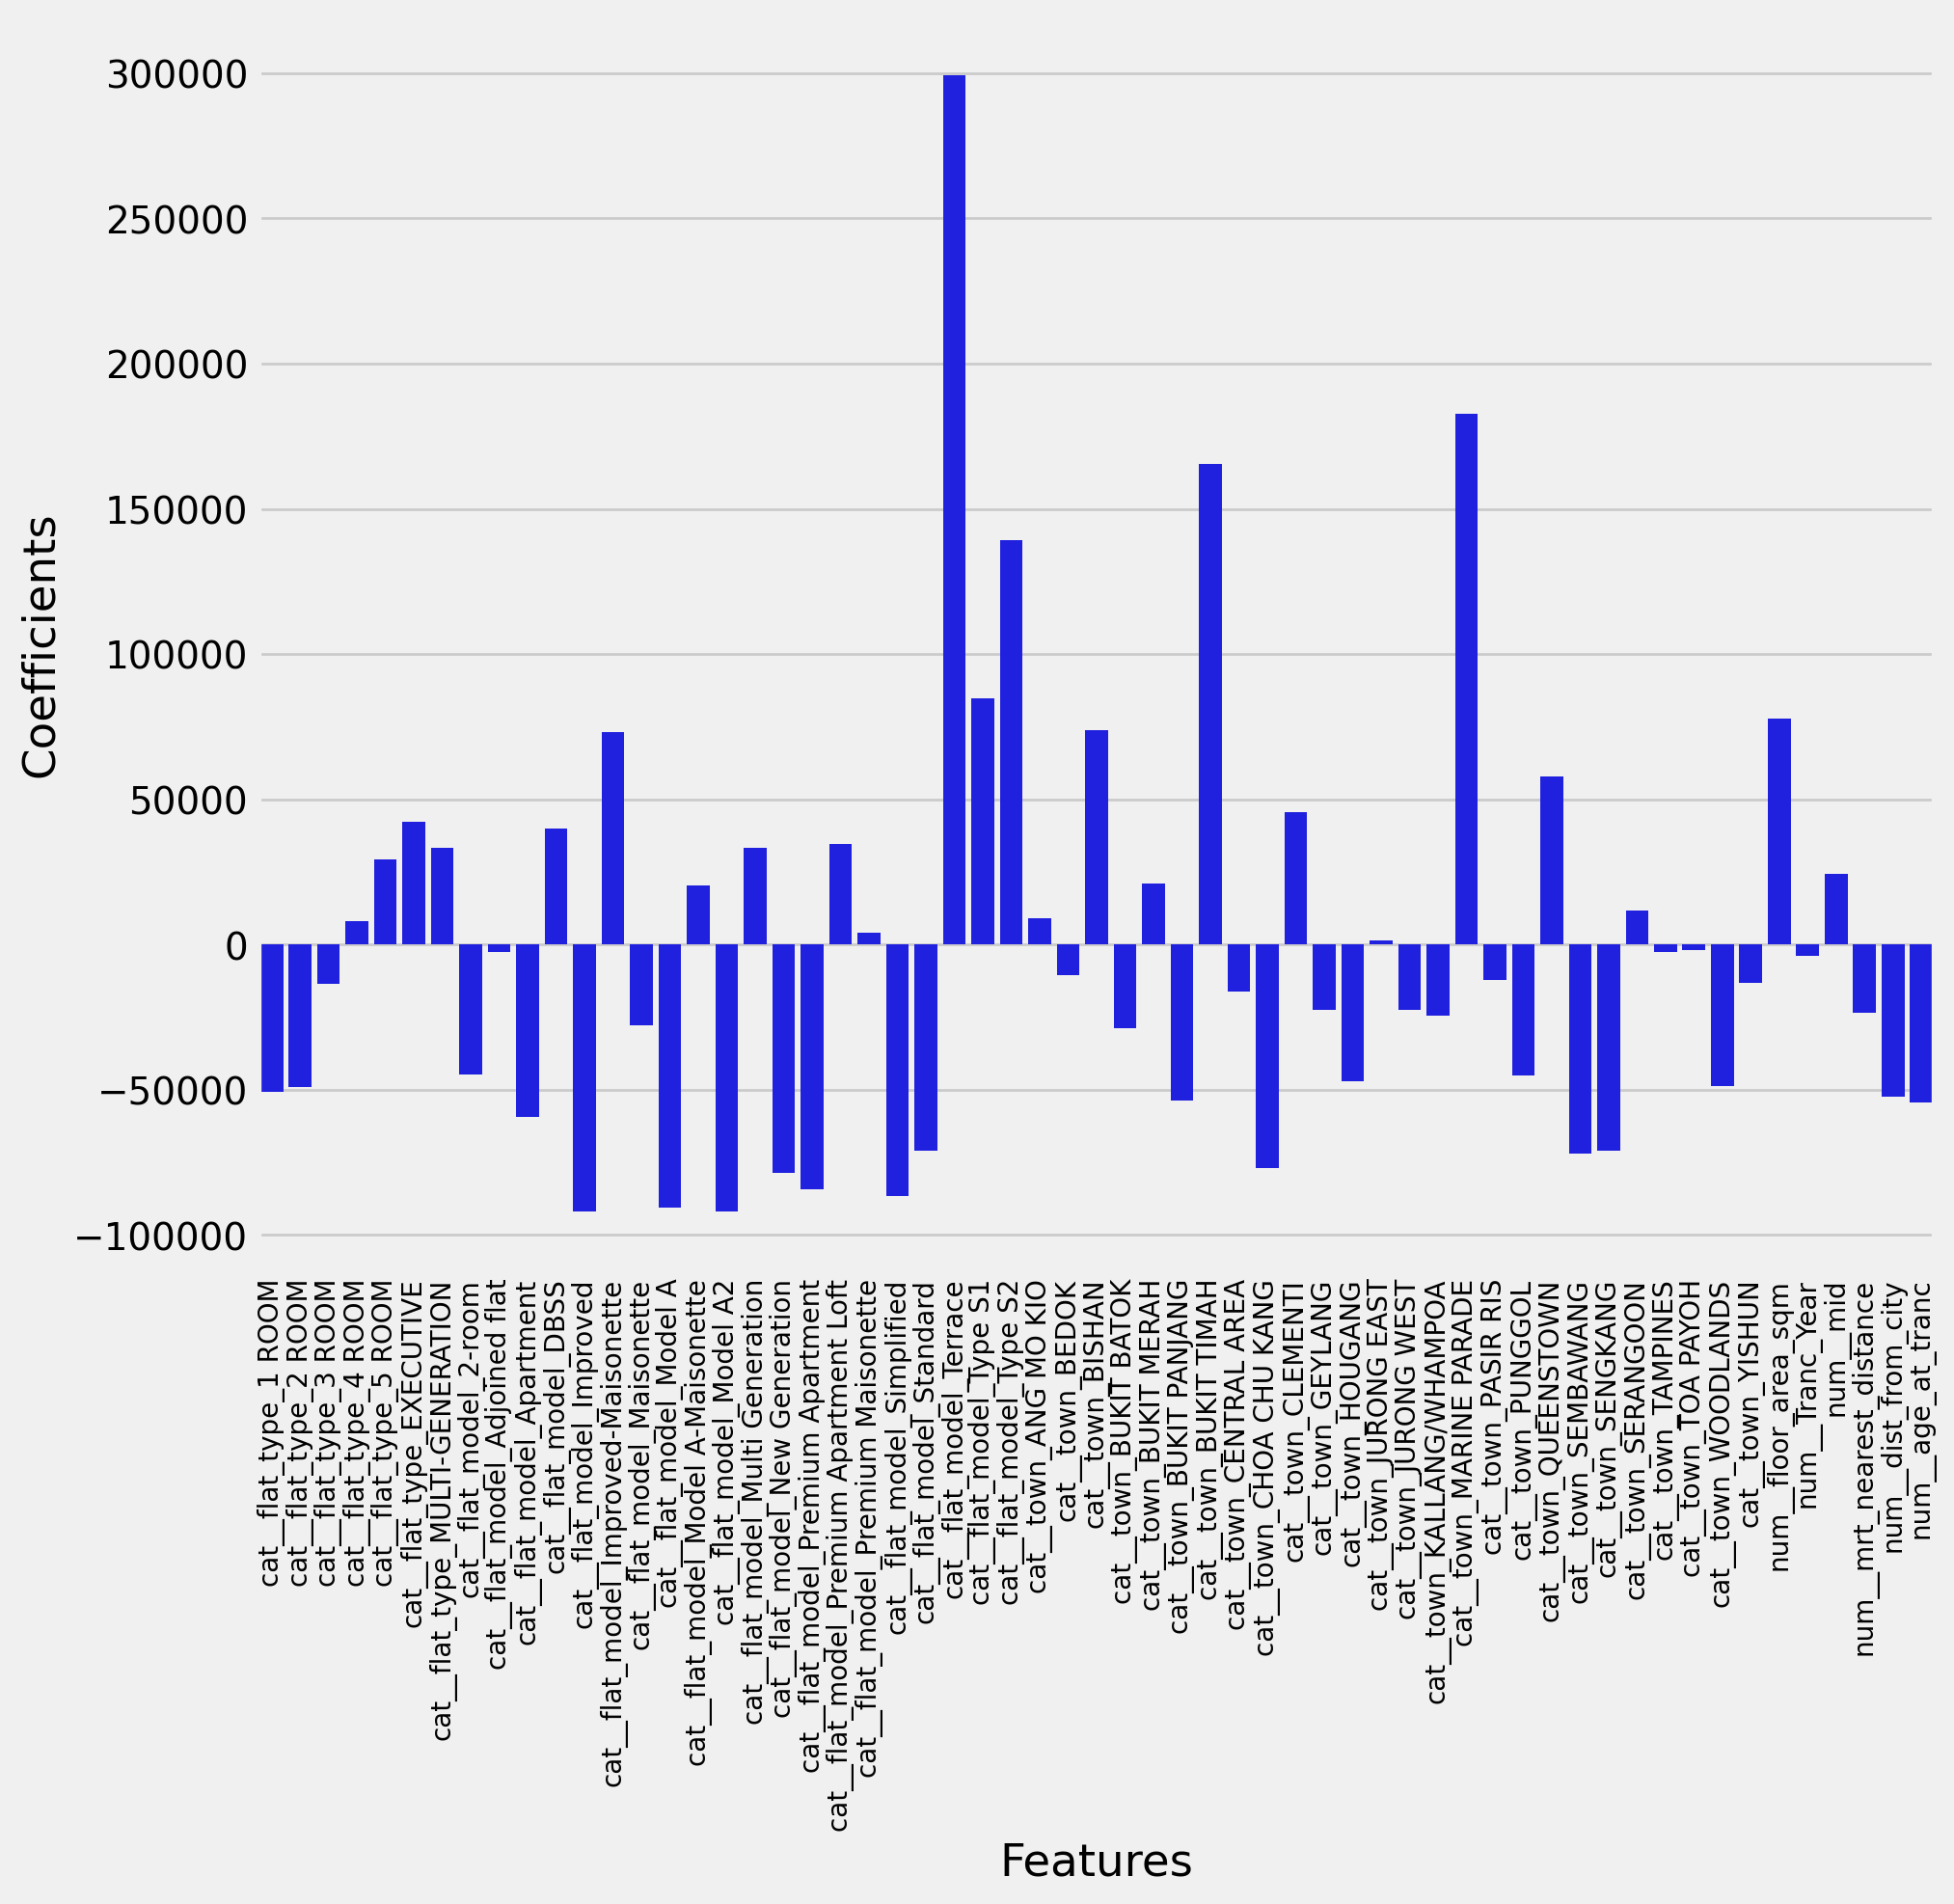

In [16]:
plt.figure(figsize=(10,8))
# create a bar chart
sns.barplot(data=df_coef, x='Features', y='Coefficients', color='blue')
plt.xticks(rotation=90, fontsize=10)
# save the chart as a PNG file
plt.savefig('./datasets/CoeffcientsLR.png')

Looking at the Linear Regression coefficients barplot above, towns and flat model are wildly overblown with their coefficients as compared to the other features. 

In [17]:
# Setting the predicted value for X_test
y_pred=pipeline_lr.predict(X_test)

# Get MSE, RMSE, MAE R^2 scores
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
score = pipeline_lr.score(X_test, y_test)
    
# Print the scores
print("R^2:", score, "\n")
print("MSE: ", mse, "\n")
print("RMSE: ", rmse, "\n")
print("MAE: ", mae, "\n")


R^2: 0.87125875622507 

MSE:  2618024983.8993454 

RMSE:  51166.63936491575 

MAE:  39243.02802251458 



The RMSE, MSE and MAE are high, in spite of having a good r2 score.

In [18]:
compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Apply Function to round off to nearest 1000
def round_to_nearest_thousands(x):
    return round(x / 1000) * 1000

compare['Predicted'] = compare['Predicted'].apply(lambda x:round_to_nearest_thousands(x))

# Get Dataframe to show the price diff between Actual and Predicted
compare['Price Diff'] = compare['Predicted'] - compare['Actual']
compare['Price Diff Percent'] = (compare['Predicted'] - compare['Actual']) / compare['Actual'] *100
compare.head(100)


,Actual,Predicted,Price Diff,Price Diff Percent
42982,355000.0,347000,-8000.0,-2.253521
108277,472000.0,580000,108000.0,22.881356
50201,625000.0,540000,-85000.0,-13.600000
45216,675000.0,541000,-134000.0,-19.851852
17365,465000.0,502000,37000.0,7.956989
...,...,...,...,...
139952,580000.0,521000,-59000.0,-10.172414
18795,660000.0,679000,19000.0,2.878788
125915,550000.0,492000,-58000.0,-10.545455
117361,340000.0,342000,2000.0,0.588235


In [19]:
# Checking how many price difference percentage above 10%
compare.loc[(compare['Price Diff Percent']<=10.0)&(compare['Price Diff Percent']>=-10)].value_counts().sum()

19144

The model is able to predict 63% of the train set that is within 10% price difference of the actual HDB housing resale price.

### Test Set Predictions (Linear Regression)

In [22]:
# Initialize an empty dictionary to store the sub_reg data
data = {'Id':[],'Predicted':[]}

# Loop through a range of ids
for id in list(house_test['id']):
    
    # Calculate the predicted price based on the id 
    # Get the sample data for the given id
    sample_data = house_test[house_test['id'] == id]
    
    # Drop the ID  as they are not required for prediction
    sample_data_pred = sample_data.drop(['id'], axis=1)
    
    # Predict the resale price using the pipeline
    predicted_price = pipeline_lr.predict(sample_data_pred)
        
    # Append the id and predicted price to the data list
    data['Id'].append(id)
    data['Predicted'].append(predicted_price[0])

In [23]:
sub_reg = pd.DataFrame(data)

In [24]:
sub_reg.head()

,Id,Predicted
0,114982,355726.493593
1,95653,516759.455734
2,40303,359120.632581
3,109506,224184.647917
4,100149,423698.706691


In [25]:
sub_reg.to_csv('./datasets/sub_reg.csv', index=False)

## Ridge Regression

### Baseline Predictions(Ridge Regression)

In [26]:
# set up the column transformer to apply OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), cat_cols), ('num', StandardScaler(), num_cols)
        ])
    
# set up the pipeline for Ridge Regression
pipeline_ridge = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge())])

In [27]:
# Checking the Ridge Regression r2 scores
pipeline_ridge_scores = cross_val_score(pipeline_lr, X, y, cv=10)

print (pipeline_ridge_scores)
print (np.mean(pipeline_ridge_scores))

[0.87129563 0.87492892 0.87473544 0.87373578 0.87343918 0.87475577
 0.87361353 0.87252337 0.87011945 0.87440957]
0.8733556645314554


In [28]:
# Fit the model with training data
pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['flat_type', 'flat_model',
                                                   'town']),
                                                 ('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'Tranc_Year', 'mid',
                                                   'mrt_nearest_distance',
                                                   'dist_from_city',
                                                   'age_at_tranc'])])),
                ('model', Ridge())])

In [29]:
print(f"The train score is: {round(pipeline_ridge.score(X_train, y_train), 6)}")
print(f"The test score is: {round(pipeline_ridge.score(X_test, y_test), 6)}")

The train score is: 0.874062
The test score is: 0.871259


The R2 scores for both train and test sets are similar, implying the model is performing well and not overfitting or underfitting the data. but the scores is slightly lower than that of Linear Regression.

In [30]:
# Obtaining the features and its corresponding coef
coef=pipeline_ridge.named_steps['model'].coef_
features=pipeline_ridge[:-1].get_feature_names_out()

In [31]:
df_coef=pd.DataFrame({'Features':features,'Coefficients':coef})
df_coef.head()

,Features,Coefficients
0,cat__flat_type_1 ROOM,-51150.516260
1,cat__flat_type_2 ROOM,-48576.416213
2,cat__flat_type_3 ROOM,-12988.404923
3,cat__flat_type_4 ROOM,8372.554059
4,cat__flat_type_5 ROOM,29639.757511


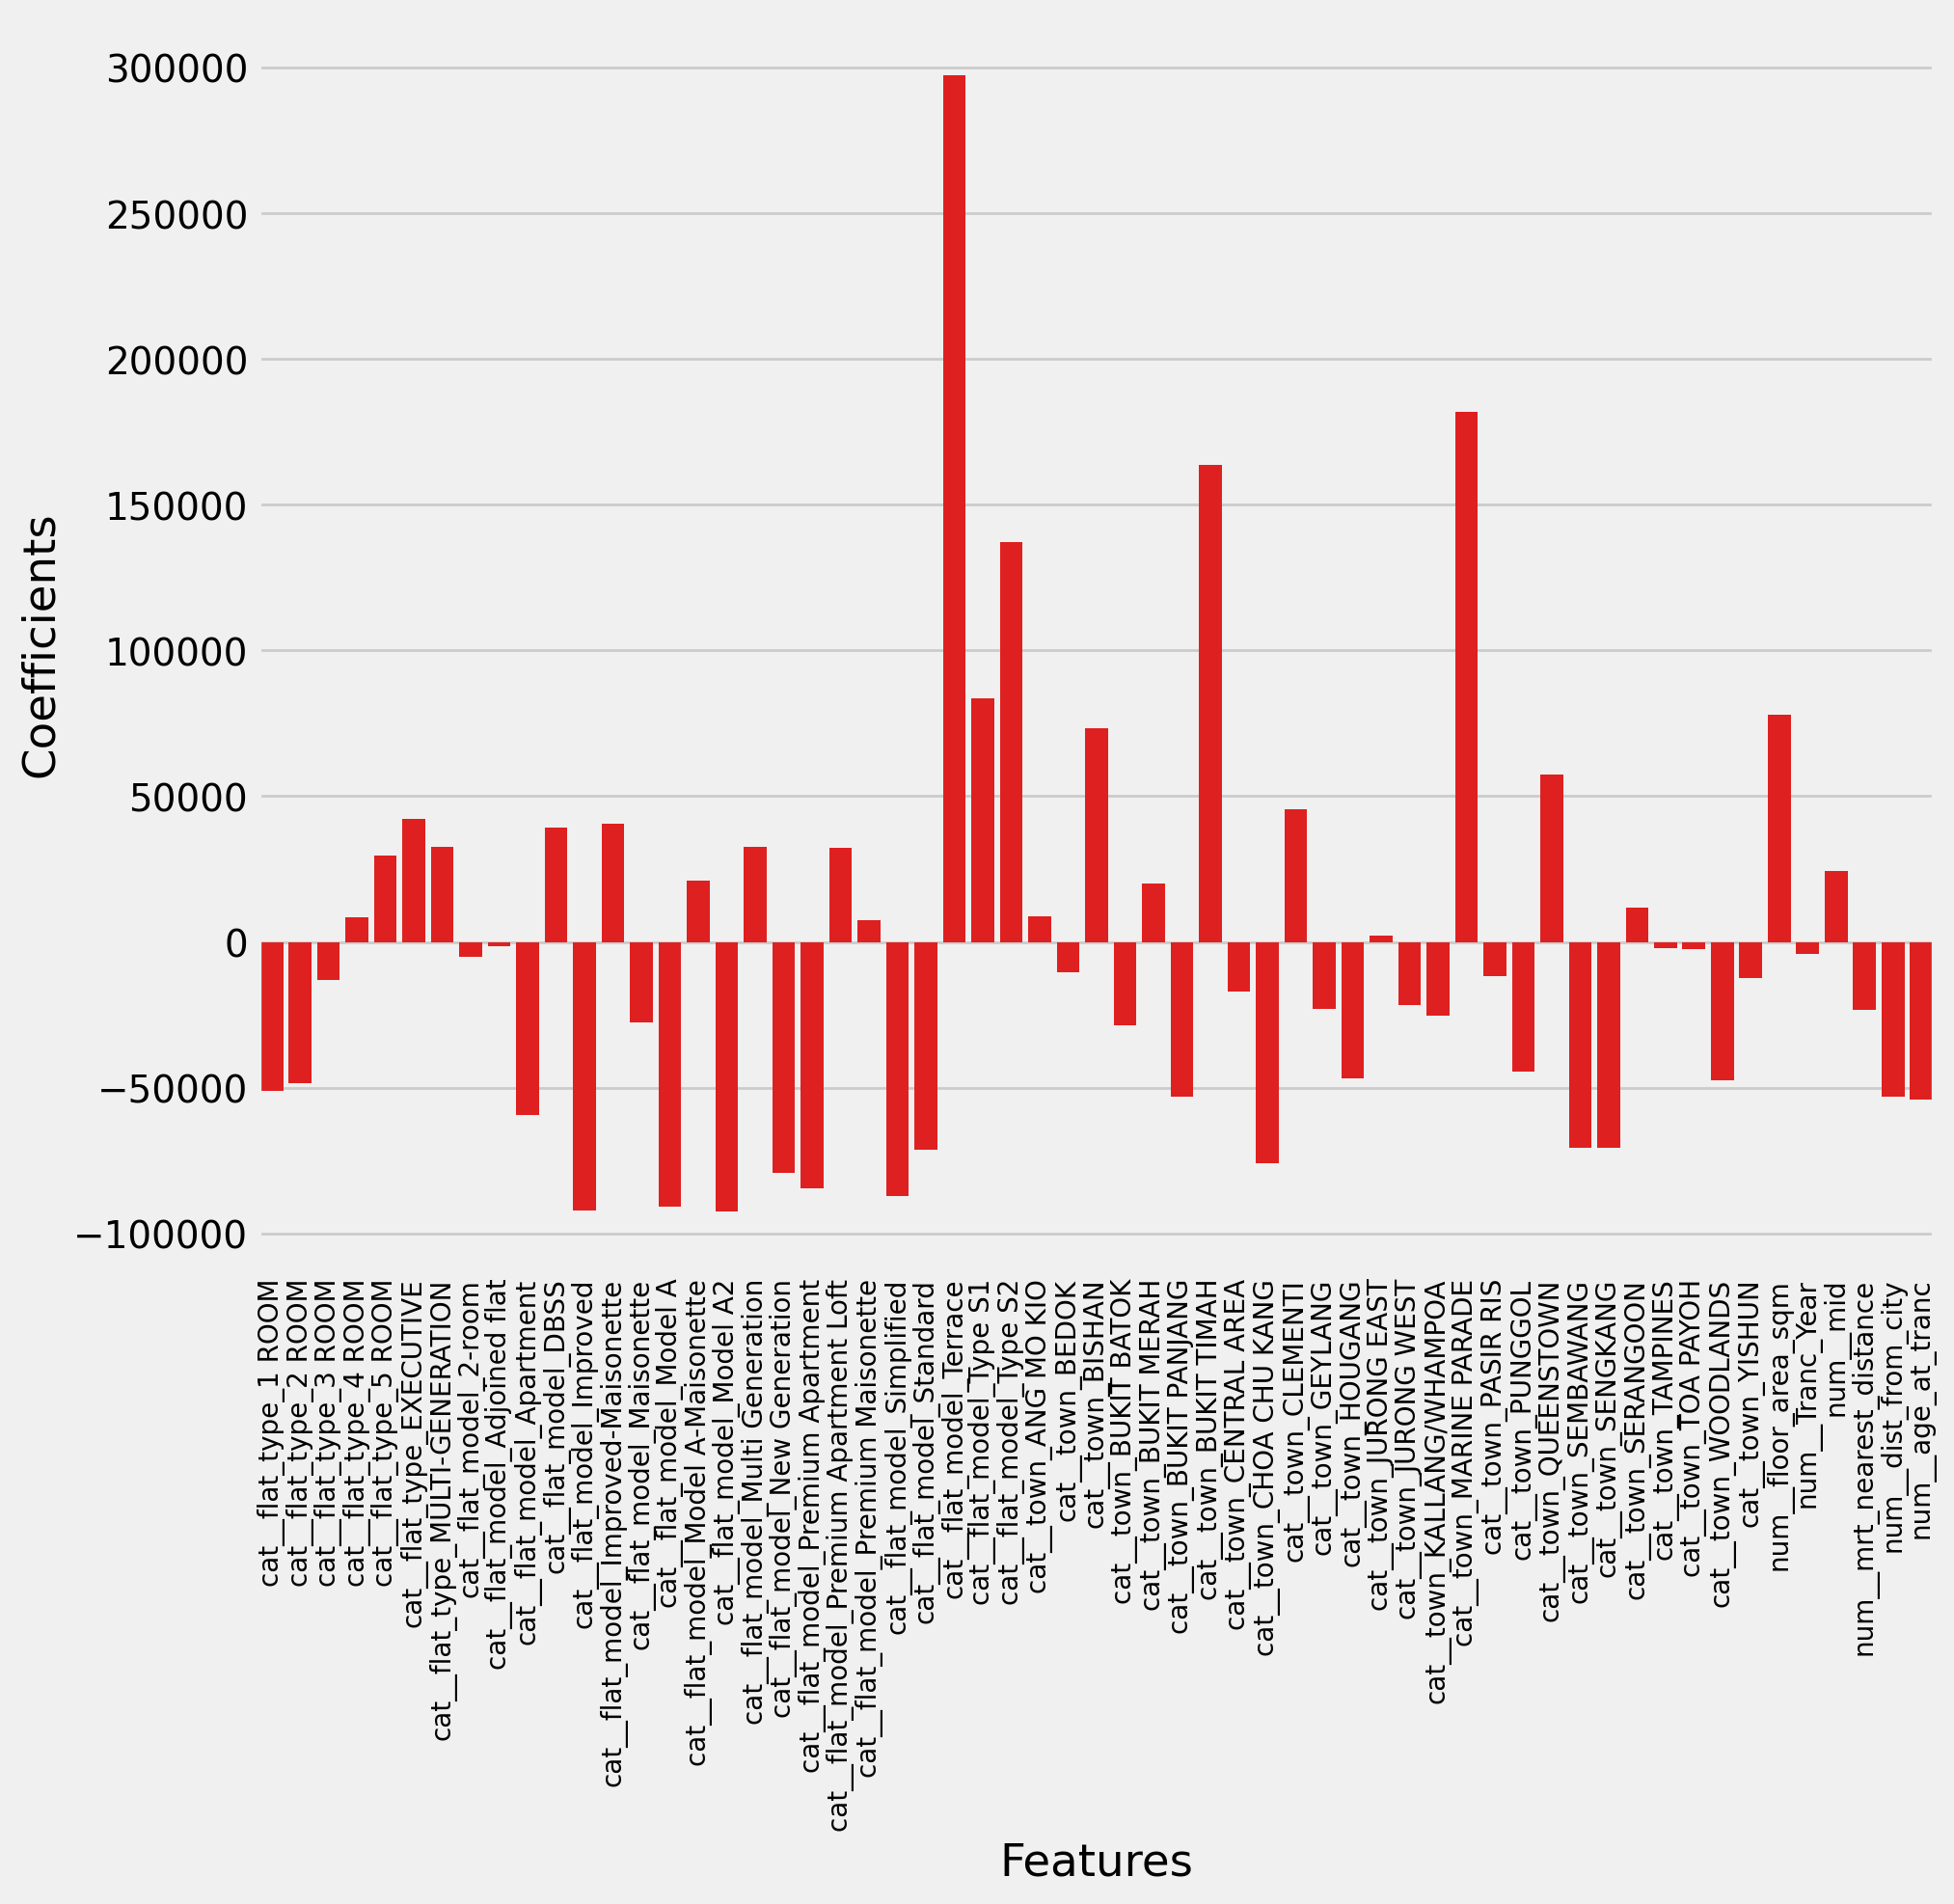

In [32]:
plt.figure(figsize=(10,8))
# create a bar chart
sns.barplot(data=df_coef, x='Features', y='Coefficients', color='red')
plt.xticks(rotation=90, fontsize=10)
# save the chart as a PNG file
plt.savefig('./datasets/CoeffcientsRidge.png')

From the above Ridge coefficients barplpot, the coefficients for town and flat model are still quite wildly overblown compared to the other features. 

In [33]:
# Setting the predicted value for X_test
y_pred=pipeline_ridge.predict(X_test)

# Get MSE, RMSE, MAE R^2 scores
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
score = pipeline_ridge.score(X_test, y_test)
    
# Print the scores
print("R^2:", score, "\n")
print("MSE: ", mse, "\n")
print("RMSE: ", rmse, "\n")
print("MAE: ", mae, "\n")


R^2: 0.8712592316623571 

MSE:  2618015315.6169877 

RMSE:  51166.54488644888 

MAE:  39241.83008762265 



The MSE, RMSE and MAE are still high, slightly than that of Linear Regression model. The r2 score is similar to that of Linear Regression model.

In [34]:
compareRidge = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Apply Function to round off to nearest 1000
def round_to_nearest_thousands(x):
    return round(x / 1000) * 1000

compareRidge['Predicted'] = compareRidge['Predicted'].apply(lambda x:round_to_nearest_thousands(x))

# Get Dataframe to show the price diff between Actual and Predicted
compareRidge['Price Diff'] = compareRidge['Predicted'] - compare['Actual']
compareRidge['Price Diff Percent'] = (compareRidge['Predicted'] - compareRidge['Actual']) / compare['Actual'] *100
compareRidge.head()

,Actual,Predicted,Price Diff,Price Diff Percent
42982,355000.0,346000,-9000.0,-2.535211
108277,472000.0,580000,108000.0,22.881356
50201,625000.0,540000,-85000.0,-13.600000
45216,675000.0,541000,-134000.0,-19.851852
17365,465000.0,502000,37000.0,7.956989


In [35]:
# Checking how many price difference percentage less than or equal 10%
compareRidge.loc[(compareRidge['Price Diff Percent']<=10.0)&(compareRidge['Price Diff Percent']>=-10)].value_counts().sum()

19145

The model is able to predict 63% of the train set that is within 10% price difference of the actual HDB housing resale price.

### Test Predictions (Ridge Regression)

In [37]:
# Initialize an empty dictionary to store the submission_ridge data
data = {'Id':[],'Predicted':[]}

# Loop through a range of ids
for id in list(house_test['id']):
    
    # Calculate the predicted price based on the id 
    # Get the sample data for the given id
    sample_data = house_test[house_test['id'] == id]
    
    # Drop the ID  as they are not required for prediction
    sample_data_pred = sample_data.drop(['id'], axis=1)
    
    # Predict the resale price using the pipeline
    predicted_price = pipeline_ridge.predict(sample_data_pred)
        
    # Append the id and predicted price to the data list
    data['Id'].append(id)
    data['Predicted'].append(predicted_price[0])

In [38]:
sub_regR=pd.DataFrame(data)

In [39]:
sub_regR.head()

,Id,Predicted
0,114982,355605.113578
1,95653,516737.245557
2,40303,359097.317994
3,109506,224022.002621
4,100149,423603.679448


In [40]:
sub_regR.to_csv('./datasets/submission_ridge.csv', index=False)

## Lasso Regression

### Baseline Predictions (Lasso Regresion)

In [41]:
# set up the column transformer to apply OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), cat_cols), ('num', StandardScaler(), num_cols)
        ])
    
# set up the pipeline for Ridge Regression
pipeline_lasso = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso())])

In [42]:
# Checking the Lasso Regression r2 scores
pipeline_lasso_scores = cross_val_score(pipeline_lr, X, y, cv=10)

print (pipeline_lasso_scores)
print (np.mean(pipeline_lasso_scores))

[0.87129563 0.87492892 0.87473544 0.87373578 0.87343918 0.87475577
 0.87361353 0.87252337 0.87011945 0.87440957]
0.8733556645314554


In [43]:
# Fit the model with training data
pipeline_lasso.fit(X_train, y_train)

C:\Users\wongh\anaconda3\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78180656341595.81, tolerance: 248089330043.785
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['flat_type', 'flat_model',
                                                   'town']),
                                                 ('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'Tranc_Year', 'mid',
                                                   'mrt_nearest_distance',
                                                   'dist_from_city',
                                                   'age_at_tranc'])])),
                ('model', Lasso())])

In [44]:
print(f"The train score is: {round(pipeline_lasso.score(X_train, y_train), 6)}")
print(f"The test score is: {round(pipeline_lasso.score(X_test, y_test), 6)}")

The train score is: 0.874069
The test score is: 0.871268


The R2 scores for both train and test sets are similar, implying the model is performing well and not overfitting or underfitting the data. The scores is teh highest among the 3 Regression models.

In [45]:
# Obtaining the features and its corresponding coef
coef=pipeline_lasso.named_steps['model'].coef_
features=pipeline_lasso[:-1].get_feature_names_out()

In [46]:
df_coef=pd.DataFrame({'Features':features,'Coefficients':coef})
df_coef.head()

,Features,Coefficients
0,cat__flat_type_1 ROOM,-69856.520986
1,cat__flat_type_2 ROOM,-70200.652117
2,cat__flat_type_3 ROOM,-34903.046943
3,cat__flat_type_4 ROOM,-13918.006150
4,cat__flat_type_5 ROOM,6994.802345


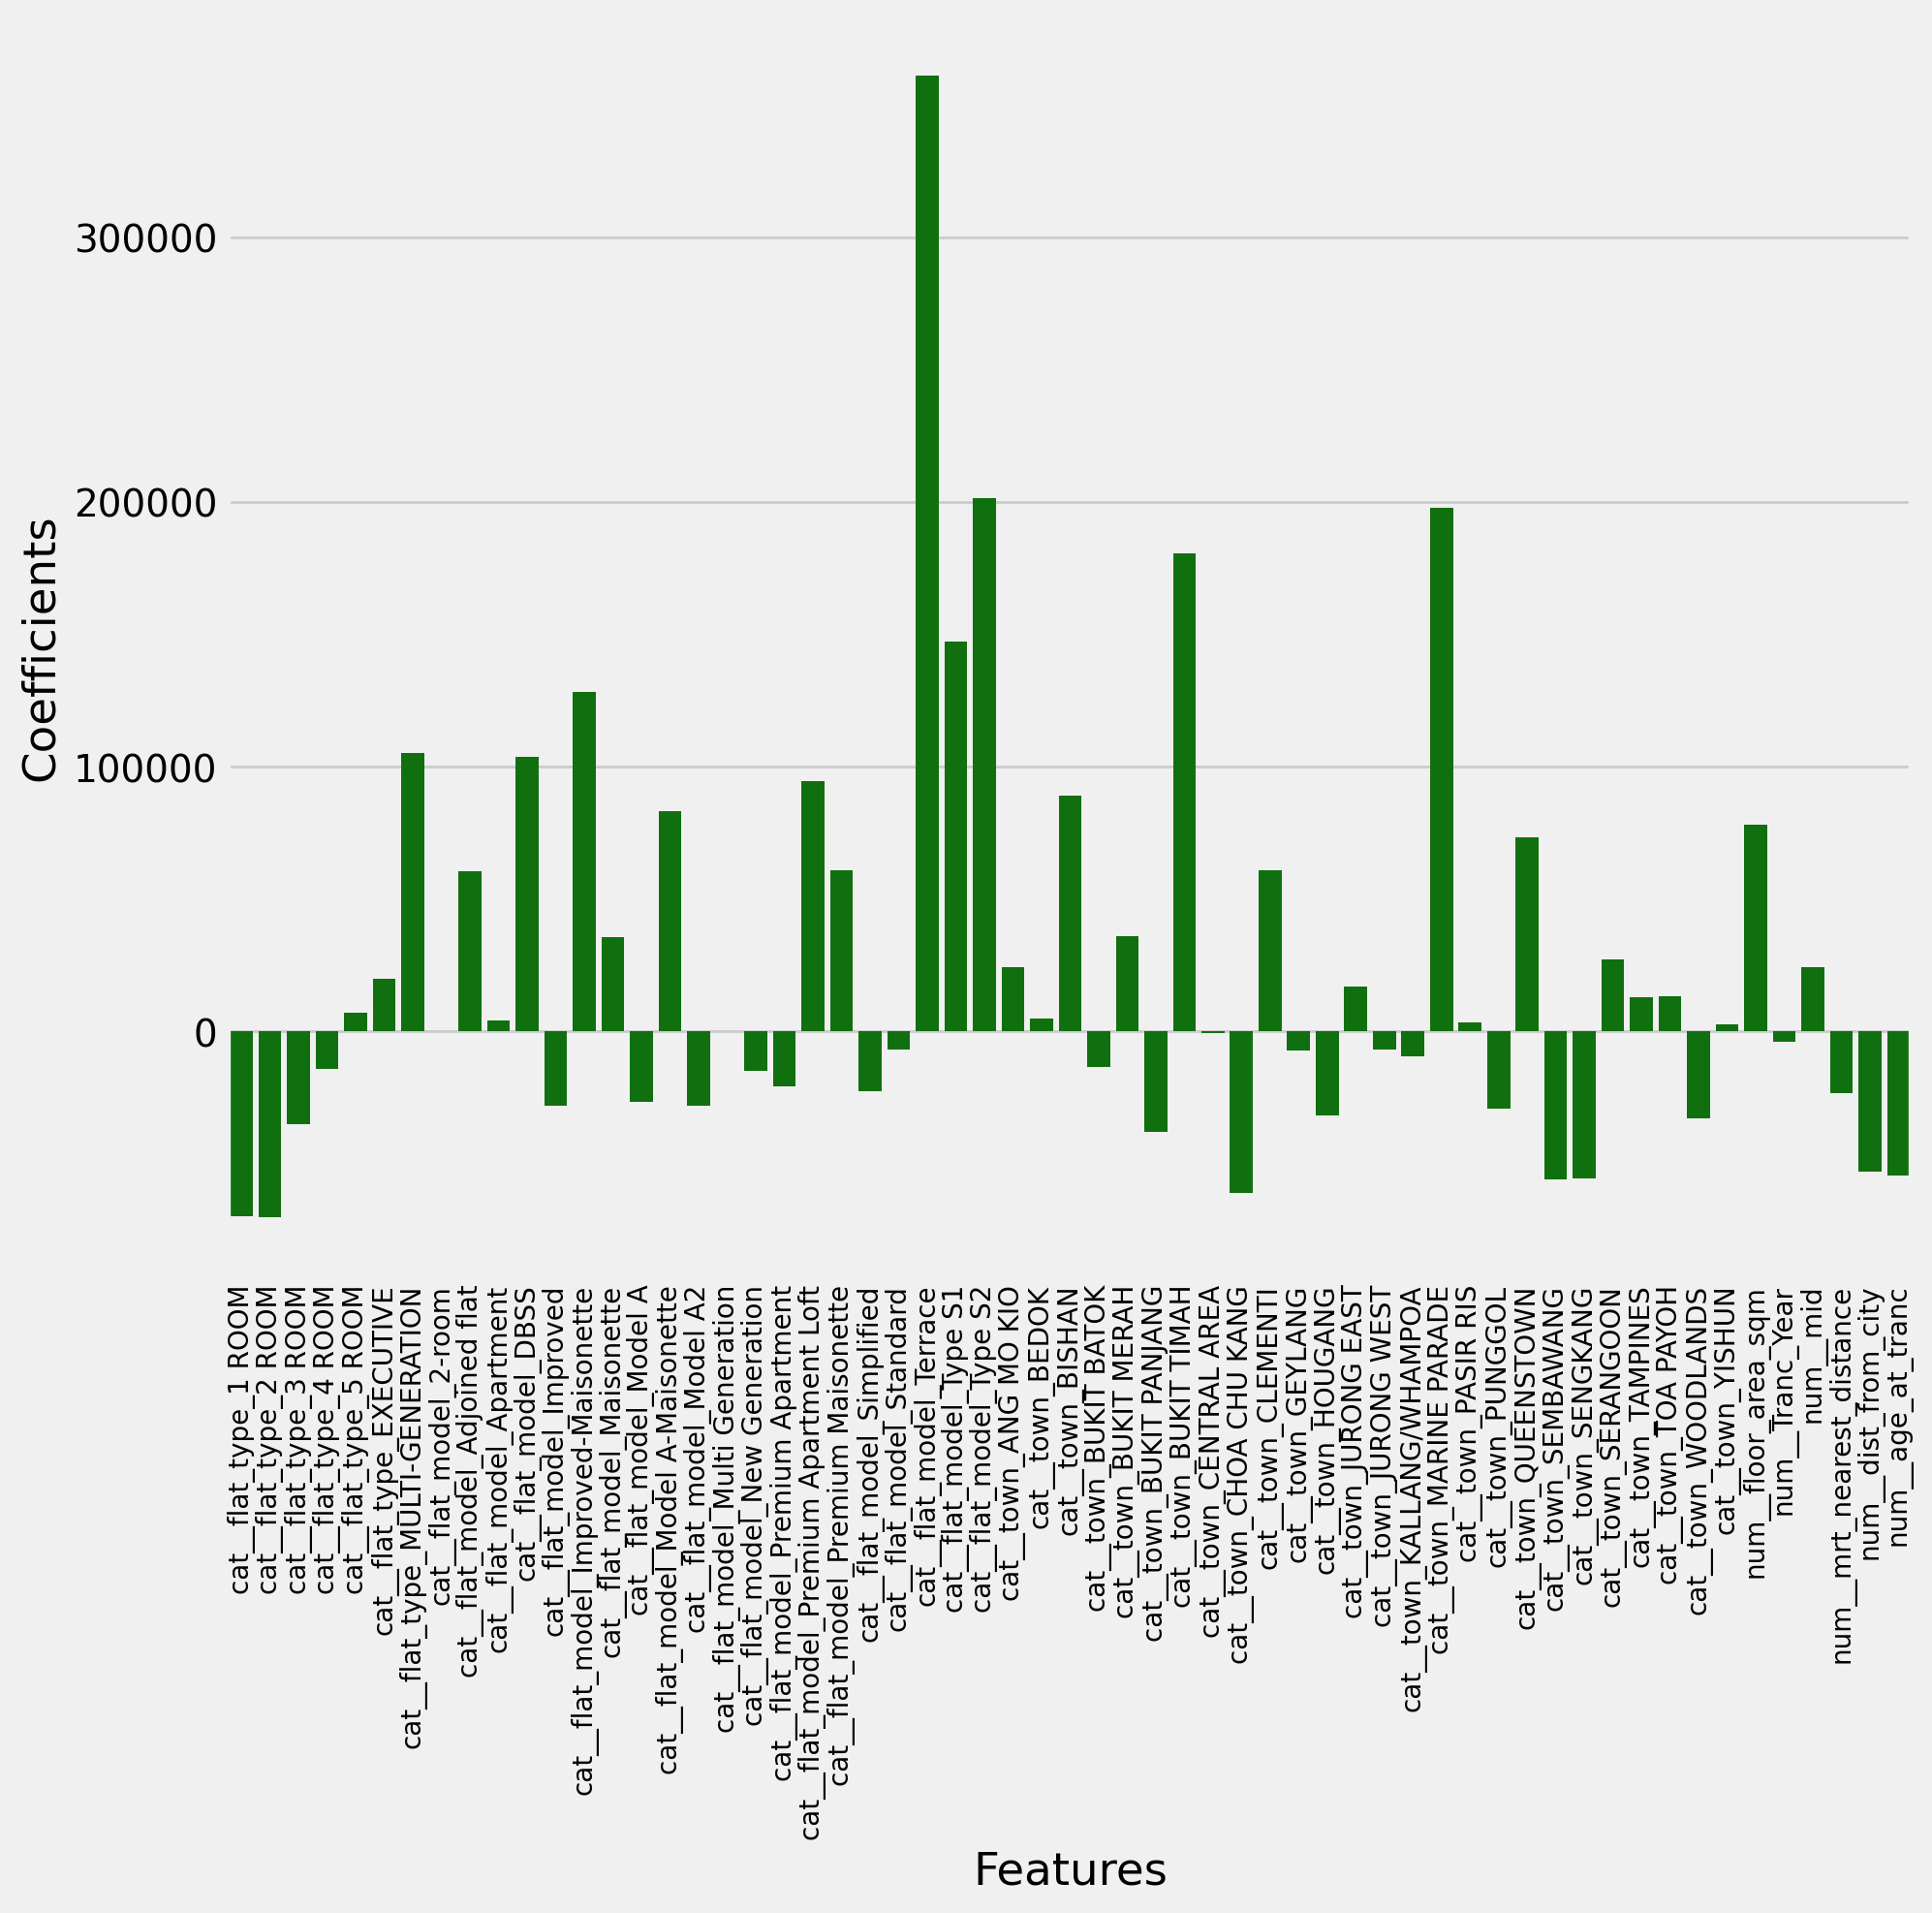

In [47]:
plt.figure(figsize=(10,8))
# create a bar chart
sns.barplot(data=df_coef, x='Features', y='Coefficients', color='green')
plt.xticks(rotation=90, fontsize=10)
# save the chart as a PNG file
plt.savefig('./datasets/CoeffcientsLasso.png')

From the above Lasso coefficients barplpot, the coefficients for town and flat model are still quite wildly overblown compared to the other features. But the flat model coefficients for this model is similar to Linear Regression model.

In [48]:
# Setting the predicted value for X_test
y_pred=pipeline_lasso.predict(X_test)

# Get MSE, RMSE, MAE R^2 scores
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
score = pipeline_lasso.score(X_test, y_test)
    
# Print the scores
print("R^2:", score, "\n")
print("MSE: ", mse, "\n")
print("RMSE: ", rmse, "\n")
print("MAE: ", mae, "\n")


R^2: 0.8712679176464682 

MSE:  2617838681.2864046 

RMSE:  51164.818784848685 

MAE:  39243.12559459949 



The MSE, RMSE and MAE are still high but slightly lower than that of Linear Regression model. The r2 score is simi;ar to the other 2 Regression models.

In [49]:
compareLasso = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Apply Function to round off to nearest 1000
def round_to_nearest_thousands(x):
    return round(x / 1000) * 1000

compareLasso['Predicted'] = compareLasso['Predicted'].apply(lambda x:round_to_nearest_thousands(x))

# Get Dataframe to show the price diff between Actual and Predicted
compareLasso['Price Diff'] = compareLasso['Predicted'] - compare['Actual']
compareLasso['Price Diff Percent'] = (compareLasso['Predicted'] - compareLasso['Actual']) / compare['Actual'] *100
compareLasso.head()

,Actual,Predicted,Price Diff,Price Diff Percent
42982,355000.0,347000,-8000.0,-2.253521
108277,472000.0,580000,108000.0,22.881356
50201,625000.0,540000,-85000.0,-13.600000
45216,675000.0,541000,-134000.0,-19.851852
17365,465000.0,502000,37000.0,7.956989


In [50]:
# Checking how many price difference percentage below and equal 10%
compareRidge.loc[(compareLasso['Price Diff Percent']<=10.0)&(compareLasso['Price Diff Percent']>=-10)].value_counts().sum()

19137

The model is able to predict 63% of the train set that is within 10% price difference of the actual HDB housing resale price, and is similar to the Ridge Regression.

### Test Predictions (Lasso Regression)

In [51]:
# Initialize an empty dictionary to store the submission_ridge data
data = {'Id':[],'Predicted':[]}

# Loop through a range of ids
for id in list(house_test['id']):
    
    # Calculate the predicted price based on the id 
    # Get the sample data for the given id
    sample_data = house_test[house_test['id'] == id]
    
    # Drop the ID  as they are not required for prediction
    sample_data_pred = sample_data.drop(['id'], axis=1)
    
    # Predict the resale price using the pipeline
    predicted_price = pipeline_lasso.predict(sample_data_pred)
        
    # Append the id and predicted price to the data list
    data['Id'].append(id)
    data['Predicted'].append(predicted_price[0])

In [52]:
sub_regL=pd.DataFrame(data)

In [53]:
sub_regL.head(10)

,Id,Predicted
0,114982,355643.556786
1,95653,516616.641725
2,40303,359072.235959
3,109506,224140.126565
4,100149,423709.717589
5,7610,319594.898471
6,61101,319103.264821
7,68167,483273.440576
8,65701,362981.932440
9,56039,270375.281457


In [54]:
sub_regL.to_csv('./datasets/submission_lasso.csv', index=False)

#### Conclusion 

From the 3 regression models that has been used to predict the HDB housing resale prices, the coefficients of the Ridge are smaller than the other 2 Regression models. I would like to try to hyperparameter tuning for both Lasso and Ridge Regression model and see whether r2 score can be imporved and the RMSE, MSE and MAE can be lowered in either Lasso or Ridge Regression.